In [1]:
import pandas as pd
import numpy as np
import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

# loading dataset into the program
dataset1 = pd.read_csv('../DataSets/London 2000-01-01 to 2024-01-31.csv', index_col="datetime")
dataset2 = pd.read_csv(r'../DataSets/tfl-daily-cycle-hires.csv', index_col="Day", parse_dates=["Day"])

# define the features we want to predict, focus on only max temperature now
# features_to_pred = ['Number of Bicycle Hires']

# Assuming ' Number of Bicycle Hires' is target feature 
target_feature = 'tempmax'

# filter dataset1 from 2010.07.30 to 2024.01.31 to fit with dataset2
start_date = pd.to_datetime('2010-07-30')
dataset1.index = pd.to_datetime(dataset1.index)
dataset1_filtered = dataset1[(dataset1.index >= start_date)]

# delete useless columns and columns with too many NaN values
dataset1_filtered.drop(columns=['name', 'severerisk', 'windgust', 
                                'preciptype', 'precipprob', 'solarradiation', 
                                'solarenergy', 'uvindex', 'sunrise', 
                                'sunset', 'conditions', 'description',	
                                'icon', 'stations', 'sunset'], 
                       inplace=True)

# combining the two datasets
merged_data = pd.merge(dataset1_filtered, dataset2, left_index=True, right_index=True, how='outer')

# change the values of bike hires to float
merged_data['Number of Bicycle Hires'] = merged_data['Number of Bicycle Hires'].apply(lambda x: float(x.replace(',', '')))

# show the merged dataset
merged_data

C:\Users\12783\AppData\Local\Temp\ipykernel_31060\1100744217.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1_filtered.drop(columns=['name', 'severerisk', 'windgust',


,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,Number of Bicycle Hires
datetime,,,,,,,,,,,,,,,,,,,
2010-07-30,22.3,14.0,17.9,22.3,14.0,17.9,10.5,63.0,0.000,0.00,0.0,0.0,21.3,250.6,1014.8,60.3,32.9,0.65,6897.0
2010-07-31,23.5,17.6,20.1,23.5,17.6,20.1,14.3,71.3,1.995,8.33,0.0,0.0,22.7,242.6,1011.6,64.1,31.1,0.68,5564.0
2010-08-01,22.8,15.3,18.8,22.8,15.3,18.8,11.7,64.8,0.000,0.00,0.0,0.0,14.6,261.1,1013.2,62.3,38.7,0.71,4303.0
2010-08-02,22.1,16.3,18.9,22.1,16.3,18.9,11.1,60.9,0.299,4.17,0.0,0.0,15.1,344.5,1016.6,63.3,36.6,0.75,6642.0
2010-08-03,21.8,13.0,18.0,21.8,13.0,18.0,11.6,67.3,0.000,0.00,0.0,0.0,20.0,247.9,1016.0,54.3,30.7,0.75,7966.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,8.6,1.1,5.0,6.6,-0.6,3.3,2.0,81.8,0.000,0.00,0.0,0.0,18.1,180.3,1032.7,33.1,15.9,0.56,16959.0
2024-01-28,11.5,3.1,7.0,11.5,0.5,5.4,4.1,82.4,0.000,0.00,0.0,0.0,13.8,169.7,1022.7,33.5,15.2,0.59,15540.0
2024-01-29,12.1,8.6,10.8,12.1,7.2,10.5,8.8,87.3,0.000,0.00,0.0,0.0,20.8,182.3,1022.0,95.9,8.4,0.62,22839.0


In [2]:
# Calculate correlation matrix 
correlation_matrix = merged_data.corr()
# Extract correlations with the target feature
correlation_with_target = correlation_matrix[target_feature].abs().sort_values(ascending=False)

# Print the correlation results 
print("Correlation with", target_feature) 
print(correlation_with_target)

# Only retain features have high correlation with target feature
features_used = list(correlation_with_target[correlation_with_target>0.1].index)
merged_data = merged_data.loc[:,features_used]

merged_data

Correlation with tempmax
tempmax                    1.000000
feelslikemax               0.992503
temp                       0.974570
feelslike                  0.968370
feelslikemin               0.896814
tempmin                    0.884250
dew                        0.822998
Number of Bicycle Hires    0.665967
humidity                   0.495428
cloudcover                 0.285385
visibility                 0.278307
snowdepth                  0.160095
precipcover                0.150653
snow                       0.116005
sealevelpressure           0.089314
windspeed                  0.073363
precip                     0.067589
winddir                    0.013696
moonphase                  0.002074
Name: tempmax, dtype: float64


,tempmax,feelslikemax,temp,feelslike,feelslikemin,tempmin,dew,Number of Bicycle Hires,humidity,cloudcover,visibility,snowdepth,precipcover,snow
datetime,,,,,,,,,,,,,,
2010-07-30,22.3,22.3,17.9,17.9,14.0,14.0,10.5,6897.0,63.0,60.3,32.9,0.0,0.00,0.0
2010-07-31,23.5,23.5,20.1,20.1,17.6,17.6,14.3,5564.0,71.3,64.1,31.1,0.0,8.33,0.0
2010-08-01,22.8,22.8,18.8,18.8,15.3,15.3,11.7,4303.0,64.8,62.3,38.7,0.0,0.00,0.0
2010-08-02,22.1,22.1,18.9,18.9,16.3,16.3,11.1,6642.0,60.9,63.3,36.6,0.0,4.17,0.0
2010-08-03,21.8,21.8,18.0,18.0,13.0,13.0,11.6,7966.0,67.3,54.3,30.7,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,8.6,6.6,5.0,3.3,-0.6,1.1,2.0,16959.0,81.8,33.1,15.9,0.0,0.00,0.0
2024-01-28,11.5,11.5,7.0,5.4,0.5,3.1,4.1,15540.0,82.4,33.5,15.2,0.0,0.00,0.0
2024-01-29,12.1,12.1,10.8,10.5,7.2,8.6,8.8,22839.0,87.3,95.9,8.4,0.0,0.00,0.0


In [3]:
# Filling in the missing data in columns by the previous day values
merged_data=merged_data.ffill()

# Checking again the number of missing data in every column after filling in the missing values
print(merged_data.isnull().sum())

tempmax                    0
feelslikemax               0
temp                       0
feelslike                  0
feelslikemin               0
tempmin                    0
dew                        0
Number of Bicycle Hires    0
humidity                   0
cloudcover                 0
visibility                 0
snowdepth                  0
precipcover                0
snow                       0
dtype: int64


In [4]:
# Checking datatypes of each column to ensure are of correct types for ML processing
print(merged_data.dtypes)

tempmax                    float64
feelslikemax               float64
temp                       float64
feelslike                  float64
feelslikemin               float64
tempmin                    float64
dew                        float64
Number of Bicycle Hires    float64
humidity                   float64
cloudcover                 float64
visibility                 float64
snowdepth                  float64
precipcover                float64
snow                       float64
dtype: object


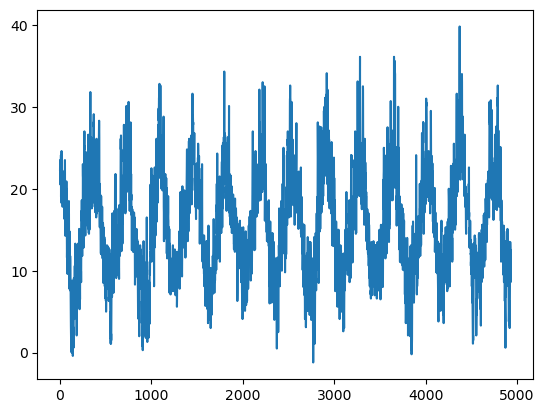

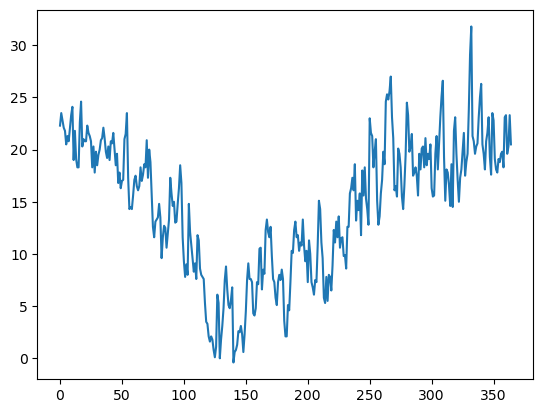

In [5]:
# Analyze the read weather data and draw temperature data
values = merged_data.loc[:, target_feature]

plt.figure()
plt.plot(range(len(values)), values)	# paint all data
plt.show()

plt.figure()
plt.plot(range(365), values[:365])  # paint data of first 365 days
plt.show()

In [6]:
# Prepare the data required for the model
# Normalise data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data)
scaled_data = pd.DataFrame(scaled_data, columns=merged_data.columns)
std = merged_data.loc[:, target_feature].std(axis=0)

# Specify the ratio of training set, validation set, and test set
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the size of the training, validation, and testing sets
train_size = int(len(scaled_data) * train_ratio)
val_size = int(len(scaled_data) * val_ratio)

lookback = 30   # use the data of last 30 days to predict
forecast = 7    # forecast the weather of next 7 days

# generate x_train and y_train
x_train = []
y_train = []
for i in range(lookback+forecast, train_size+1):
    x_train.append(scaled_data[i-lookback-forecast:i-forecast])
    y_train.append(scaled_data.loc[i-forecast:i-1, target_feature])
x_train, y_train = np.array(x_train), np.array(y_train)

# generate x_val and y_val
x_val = []
y_val = []
for i in range(train_size+forecast, train_size+val_size+1):
    x_val.append(scaled_data[i-lookback-forecast:i-forecast])
    y_val.append(scaled_data.loc[i-forecast:i-1, target_feature])
x_val, y_val = np.array(x_val), np.array(y_val)

# generate x_test and y_test
x_test = []
y_test = []
for i in range(train_size+val_size+forecast, len(scaled_data)):
    x_test.append(scaled_data[i-lookback-forecast:i-forecast])
    y_test.append(scaled_data.loc[i-forecast:i-1, target_feature])
x_test, y_test = np.array(x_test), np.array(y_test)

In [7]:
std

6.365339010945297

In [8]:
# A common sense based, non machine learning method is 
# used to calculate the MAE (Mean Absolute Error) of a 
# common sense based method that always predicts that 
# the next day's data is equal to the previous day's data.
# data_to_pred = merged_data.loc[:, [target_feature]]
# diff_data_val = np.diff(data_to_pred, axis=0)[lookback + train_size:train_size + val_size]
# mae = np.mean(np.abs(diff_data_val), axis=0)

target_feature_index = merged_data.columns.get_loc(target_feature)
y_pred = np.empty(y_test.shape)
for i in range(x_test.shape[0]):
    y_pred[i] = np.full((1, 7), x_test[i, -1, target_feature_index])
error = y_pred - y_test
mae = np.mean(np.abs(error), axis=0)*std

print("Reference Error of "+target_feature+':\n', mae)

Reference Error of tempmax:
 [1.87893701 2.41441362 2.73270201 2.90547156 3.11652837 3.2221249
 3.3777265 ]


In [9]:
x_test

array([[[-1.65244847, -1.80089864, -1.66264734, ..., -0.07494366,
         -0.69896242, -0.05328173],
        [-0.75688302, -0.62663184, -0.70331583, ..., -0.07494366,
          0.24184475, -0.05328173],
        [-0.78830637, -0.6552725 , -0.61107242, ..., -0.07494366,
          4.4771711 , -0.05328173],
        ...,
        [-1.38535   , -1.19944492, -1.66264734, ..., -0.07494366,
         -0.22799412, -0.05328173],
        [-0.99255814, -1.19944492, -0.99849476, ..., -0.07494366,
         -0.69896242, -0.05328173],
        [-1.49533172, -1.75793766, -1.44126314, ..., -0.07494366,
         -0.69896242, -0.05328173]],

       [[-0.75688302, -0.62663184, -0.70331583, ..., -0.07494366,
          0.24184475, -0.05328173],
        [-0.78830637, -0.6552725 , -0.61107242, ..., -0.07494366,
          4.4771711 , -0.05328173],
        [-1.10253986, -1.04192132, -0.88780266, ..., -0.07494366,
          3.06539565, -0.05328173],
        ...,
        [-0.99255814, -1.19944492, -0.99849476, ..., -

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 128)         56064     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 93,377
Trainable params: 93,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
26/26 [==============================] - 11s 204ms/step - loss: 0.5451 - val_loss: 0.6530
Epoch 2/20
26/26 [==============================] - 4s 168ms/step - loss: 0.4827 - val_loss: 0.5882
Epoch 3/20
26/26 [==============================] - 4s 167ms/step - loss: 0.4690 - val_loss: 0.5866
Epoch 4/20
26/2

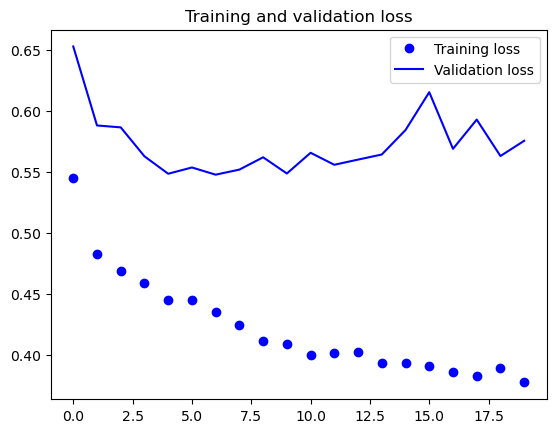

Test error: Number of Bicycle Hires    3778.993455
dtype: float64


In [15]:
# Train and evaluate a stacked GRU model using dropout regularization
model = Sequential()
model.add(layers.GRU(128,
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, scaled_data.shape[-1])))
model.add(layers.GRU(64,
                     activation='relu',
                     dropout=0.2,
                     recurrent_dropout=0.5))
model.add(layers.Dense(forecast))
model.summary()

# Compile and train the model
model.compile(optimizer=RMSprop(learning_rate=0.002), loss='mae')
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_val, y_val))

# paint the result
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# test the model
score = model.evaluate(x_test, y_test, verbose=0)
# denormalization the error, which shows the average error
# measured in Celsius degree.
print('Test error:', score * std)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          6016      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 7)                 119       
                                                                 
Total params: 9,271
Trainable params: 9,271
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
27/27 [==============================] - 10s 128ms/step - loss: 0.6673 - val_loss: 0.5384
Epoch 2/20
27/27 [==============================] - 3s 102ms/step - loss: 0.4915 - val_loss: 0.4937
Epoch 3/20
27/27 [==============================] - 3s 103ms/step - loss: 0.4533 - val_loss: 0.4599
Epoch 4/20
27/27 

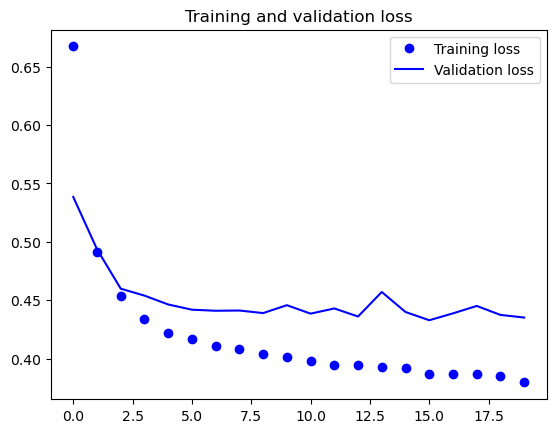

Test error: 2.724720048641


In [56]:
# Train and evaluate a stacked LSTM model using dropout regularization
model = Sequential()
model.add(layers.LSTM(32,
                      dropout=0.1,
                      recurrent_dropout=0.5,
                      return_sequences=True,
                      input_shape=(None, scaled_data.shape[-1])))
model.add(layers.LSTM(16,
                      activation='relu',
                      dropout=0.1,
                      recurrent_dropout=0.5))
model.add(layers.Dense(forecast))
model.summary()

# compile and train the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='mae')
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_val, y_val))

# paint the result
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# test the model
score = model.evaluate(x_test, y_test, verbose=0)
# denormalization the error, which shows the average error
# measured in Celsius degree.
print('Test error:', score * std)

In [10]:
model.predict(x_test[0:0+1,:,:])

NameError: name 'model' is not defined

In [12]:
x_test.shape

(734, 30, 14)

In [62]:
error = model.predict(x_test) - y_test
mae = np.mean(np.abs(error), axis=0)*std

print("Average Error of "+target_feature+':\n', mae)

23/23 [==============================] - 0s 16ms/step
Average Error of tempmax:
 [2.40406755 2.57466539 2.71924344 2.77298265 2.81822695 2.87922961
 2.90462467]
